In [1]:
# Load libraries
import sys
import sys
sys.path.append("../../xapres_package/")
import ApRESDefs
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker 

import xarray as xr
import importlib
import pandas as pd
import math
from datetime import datetime, timedelta, date
from scipy.stats import linregress


importlib.reload(ApRESDefs)
xa = ApRESDefs.xapres(loglevel='debug')

DEBUG    22:34:56 	 ApRESDefs.py @function _setup_logging line 615 - Stream logging level set to DEBUG
DEBUG    22:34:56 	 ApRESDefs.py @function _setup_logging line 616 - Add console handler to logger
DEBUG    22:34:56 	 ApRESDefs.py @function _setup_logging line 629 - File logging level set to DEBUG


In [2]:
# Load data
def reload(site):
    filename = f'gs://ldeo-glaciology/apres/greenland/2022/single_zarrs_noencode/{site}'
    ds = xr.open_dataset(filename,
        engine='zarr', 
        chunks={}) 
    return ds

ds_101 = reload("A101")
ds_103 = reload("A103_fixed")
ds_104 = reload("A104")

ds_101 = ds_101.isel(time=range(20,len(ds_101.time)))
ds_103 = ds_103.isel(time=range(60,len(ds_103.time)))
ds_104 = ds_104.isel(time=range(50,len(ds_104.time)))


def reload_winter(site):
    filename = f'gs://ldeo-glaciology/apres/greenland/2022/single_zarrs_noencode/{site}_winter22_23'
    ds = xr.open_dataset(filename,
        engine='zarr', 
        consolidated=True, 
        chunks={}) 
    return ds

ds_101_w = reload_winter("A101")
ds_103_w = reload_winter("A103")
ds_104_w = reload_winter("A104")

def reload_summer(site):
    filename = f'gs://ldeo-glaciology/apres/greenland/2022/single_zarrs_noencode/{site}_summer_23'
    ds = xr.open_dataset(filename,
        engine='zarr', 
        consolidated=True, 
        chunks={}) 
    return ds

ds_101_s = reload_summer("A101")
ds_103_s = reload_summer("A103")
ds_104_s = reload_summer("A104")

In [3]:
from dask.distributed import Client

client = Client("tcp://127.0.0.1:33059")
client

<Client: 'tcp://127.0.0.1:33059' processes=4 threads=16, memory=125.81 GiB>

In [4]:
def custom_stacked_profile_series(chirps,pad=2,F0=2e8,F1=4e8):
    StartFreq = 2e8
    StopFreq = 4e8
    B = StopFreq - StartFreq
    CentreFreq = B/2
    K = 2e8 
    dt = 1/40000
    c0 = 3e8 # speed of light in vaccuum
    ER_ICE = 3.18
    T0 = (F0-StartFreq)/K
    T1 = (F1-StartFreq)/K

    chirps = chirps.isel(chirp_time=range(math.ceil(T0/dt),math.floor(T1/dt)+1)).mean(dim='chirp_num')
    window = np.blackman(len(chirps.chirp_time))
    win_chirps = chirps*window
    Nt = len(chirps.chirp_time)
    Nfft = math.floor(Nt*pad)
    bin2m = c0/(2.*(T1-T0)*pad*math.sqrt(ER_ICE)*K)
    profile_range = np.asarray([i for i in range(Nfft)]) * bin2m      
    profile_range = profile_range[0:math.floor(Nfft/2)-1]
    padchirp = np.zeros((len(chirps.time),Nfft))
    padchirp[:,0:math.floor(Nt/2)] = win_chirps.data[:,math.floor(Nt/2):-1]
    padchirp[:,-math.floor(Nt/2):] = win_chirps.data[:,0:math.floor(Nt/2)]
    p = np.fft.fft(padchirp,axis=1)/Nfft * math.sqrt(2*pad)
    profile = p[:,0:math.floor(Nfft/2)-1]
    m = np.asarray([i for i in range(profile.shape[1])])/pad
    phiref = 2*math.pi*CentreFreq*m/B - m * m * 2*math.pi * K/2/B**2
    profile_ref = profile * np.exp(phiref[np.newaxis,:]*(-1j))
    profile_range = np.asarray([i for i in range(Nfft)]) * bin2m      
    profile_range = profile_range[0:math.floor(Nfft/2)-1]
    n = np.argmin(profile_range<=1400)
    Range = profile_range[:n]
    Profile = profile_ref[:,:n]
    da = xr.DataArray(Profile,
                  dims=['time','profile_range'],
                  coords={'profile_range': Range,
                         'time': chirps.time.data})
    return da
    
def generate_strain_fit(ds,window,lag):
    b1= ds.isel(time=range(0,len(ds)-lag))
    b2 = ds.isel(time=range(lag,len(ds)))
    ds_full, co_full, phi_full = xa.generate_range_diff(b1,b2,window,window,None,0,0.95)
    ds_full=ds_full.assign(coherence=(['time','profile_range'],co_full))
    ds_new = ds_full.where(abs(ds_full.coherence) > 0.95).drop_duplicates('time')

    vv = ds_new.range_diff / ds_new.time_diff * 31536000
    vv_err = ds_new.err / ds_new.time_diff * 31536000
    vv_top = vv.where(vv.profile_range <=600)
    fit_top = vv_top.polyfit('profile_range',1,full=True)
    vv_bottom = vv.where(vv.profile_range > 500)
    fit_bottom = vv_bottom.polyfit('profile_range',1,full=True)
    r2_top = 1-fit_top.polyfit_residuals/((vv_top-vv_top.mean())**2).sum(dim='profile_range')
    r2_bottom = 1-fit_bottom.polyfit_residuals/((vv_bottom-vv_bottom.mean())**2).sum(dim='profile_range')
    
    fig, axs = plt.subplots(nrows=2,figsize=(10,6),sharex=True)
    axs[0].plot(fit_top.time.values,fit_top.polyfit_coefficients.sel(degree=1).values,label='Top')
    axs[0].plot(fit_bottom.time.values,fit_bottom.polyfit_coefficients.sel(degree=1).values,label='Bottom')
    #axs[0].set_ylim([-1e-2,1e-2])
    axs[0].set_ylabel('Strain rate [y$^{-1}$]')
    axs[0].set_title('Strain fitting results')
    axs[1].plot(fit_top.time.values,r2_top.values,label='Top')
    axs[1].plot(fit_bottom.time.values,r2_bottom.values,label='Bottom')
    axs[1].set_xlabel('Date')
    axs[1].set_ylabel('r$^2$')
    return ds_new,fit_top, fit_bottom

In [5]:
da_101_stacked  = custom_stacked_profile_series(ds_101.chirp.isel(attenuator_setting_pair=1,time=range(3800,5500)),2,3e8,4e8)


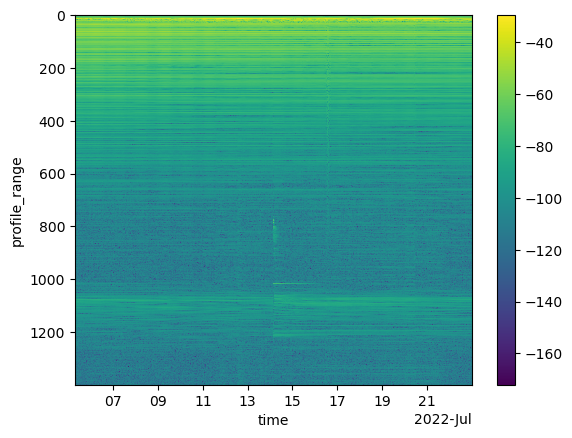

In [6]:
xa.dB(da_101_stacked).plot(x='time')
plt.gca().invert_yaxis()


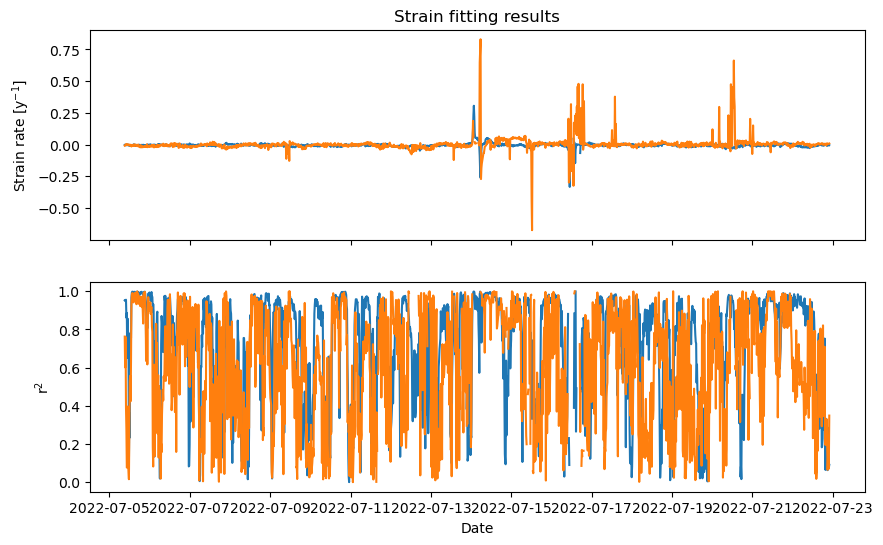

In [7]:
best_window = 80
best_lag = 16
ds_new, fit_t, fit_b = generate_strain_fit(da_101_stacked,best_window,best_lag)

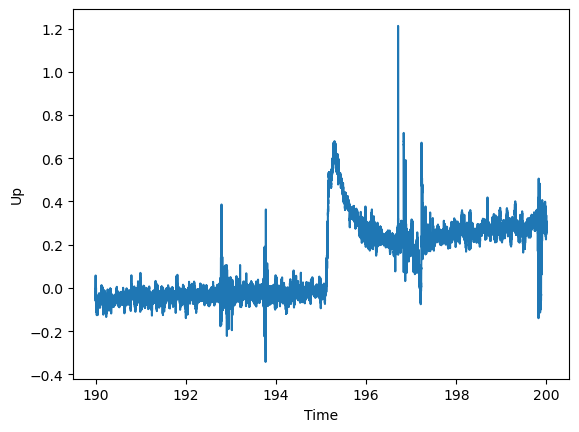

In [9]:
colnames = ['Time','East','North','Up','sigma_east','sigma_north','sigma_up']
data = pd.read_csv('sq11_YY_MM_DD_HR_MIN_SEC.txt', sep=" ", names=colnames, header=None)
#data['datetime']=  pd.to_datetime(
#                      data['Time'], unit='D', origin=pd.Timestamp('2021-12-31')
#                      )

data = data.set_index('Time')
data = data.to_xarray()
data.Up.plot(x='Time')

In [10]:
ds_new['doy_decimal'] = ds_new.time.dt.dayofyear + (ds_new.time.dt.hour / 24) + (ds_new.time.dt.minute / 1440) + (ds_new.time.dt.second / 86400)
fit_t['doy_decimal'] = fit_t.time.dt.dayofyear + (fit_t.time.dt.hour / 24) + (fit_t.time.dt.minute / 1440) + (fit_t.time.dt.second / 86400)
fit_b['doy_decimal'] = fit_b.time.dt.dayofyear + (fit_b.time.dt.hour / 24) + (fit_b.time.dt.minute / 1440) + (fit_b.time.dt.second / 86400)

da_101_stacked['doy_decimal'] = da_101_stacked.time.dt.dayofyear + (da_101_stacked.time.dt.hour / 24) + (da_101_stacked.time.dt.minute / 1440) + (da_101_stacked.time.dt.second / 86400)


(193.0, 197.0)

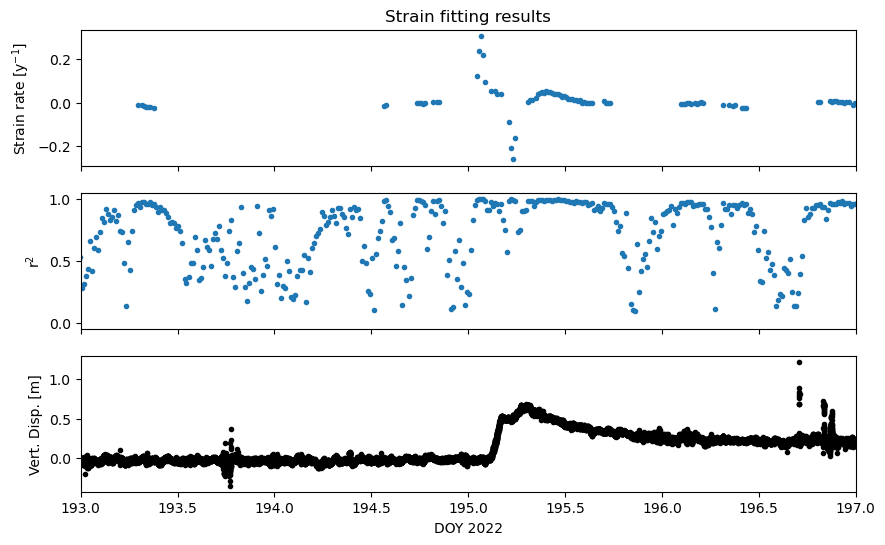

In [11]:
fig, axs = plt.subplots(nrows=3,figsize=(10,6),sharex=True)

vv = ds_new.range_diff / ds_new.time_diff * 31536000
vv_err = ds_new.err / ds_new.time_diff * 31536000
vv_top = vv.where(vv.profile_range <=600)
r2_t = 1-fit_t.polyfit_residuals/((vv_top-vv_top.mean())**2).sum(dim='profile_range')

axs[0].plot(fit_t.where(r2_t>0.95).doy_decimal.values,fit_t.where(r2_t>0.95).polyfit_coefficients.sel(degree=1).values,linestyle='None',marker='.')
axs[0].set_ylabel('Strain rate [y$^{-1}$]')
axs[0].set_title('Strain fitting results')

axs[1].plot(fit_t.doy_decimal.values,r2_t.values,linestyle='None',marker='.')
axs[1].set_ylabel('r$^2$')
data.Up.plot(ax=axs[2],x='Time',color='k',linestyle='None',marker='.')
axs[2].set_xlabel('DOY 2022')
axs[2].set_ylabel('Vert. Disp. [m]')
axs[2].set_xlim([193,197])

(193.0, 197.0)

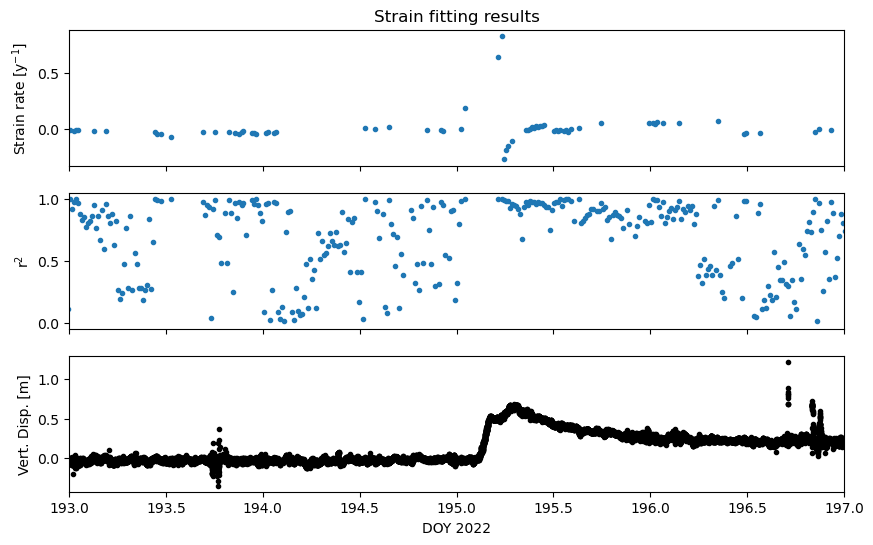

In [12]:
fig, axs = plt.subplots(nrows=3,figsize=(10,6),sharex=True)

vv = ds_new.range_diff / ds_new.time_diff * 31536000
vv_err = ds_new.err / ds_new.time_diff * 31536000
vv_bottom = vv.where(vv.profile_range > 500)
r2_b = 1-fit_b.polyfit_residuals/((vv_bottom-vv_bottom.mean())**2).sum(dim='profile_range')

axs[0].plot(fit_b.where(r2_b>0.95).doy_decimal.values,fit_b.where(r2_b>0.95).polyfit_coefficients.sel(degree=1).values,linestyle='None',marker='.')
axs[0].set_ylabel('Strain rate [y$^{-1}$]')
axs[0].set_title('Strain fitting results')
axs[1].plot(fit_b.doy_decimal.values,r2_b.values,linestyle='None',marker='.')
axs[1].set_ylabel('r$^2$')
data.Up.plot(ax=axs[2],x='Time',color='k',linestyle='None',marker='.')
axs[2].set_xlabel('DOY 2022')
axs[2].set_ylabel('Vert. Disp. [m]')
axs[2].set_xlim([193,197])

Text(0.5, 0.01, 'vertical velocity [m y$^{-1}$]')

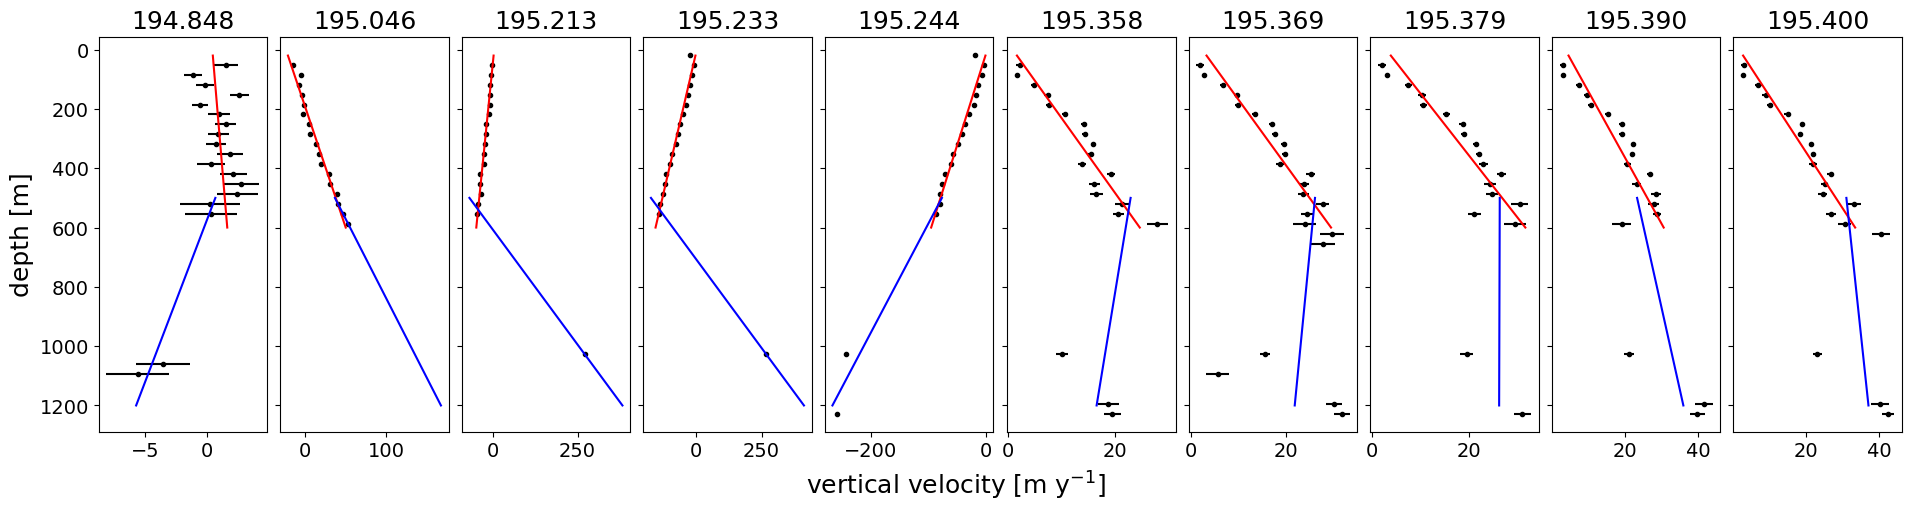

In [13]:
fig1, axs_1 = plt.subplots(ncols=10,figsize=(19,5),sharey=True,layout='constrained')
#fig1.suptitle('Strain fitting (\u03B5\u0307 in 10$^{-3}$ yr$^{-1}$)',fontsize=18)
filter_fit_top = fit_t.where(r2_t>0.95).where( r2_b>0.95).dropna(dim='time',how='all')
filter_fit_bottom = fit_b.where(r2_t>0.95).where(r2_b>0.95).dropna(dim='time',how='all')
filter_vv = vv.where(r2_t>0.95).where(r2_b>0.95).dropna(dim='time',how='all')
filter_vv_err = vv_err.where(r2_t>0.95).where(r2_b>0.95).dropna(dim='time',how='all')

filter_vv['doy_decimal'] = filter_vv.time.dt.dayofyear + ((filter_vv.time.dt.hour) / 24) + (filter_vv.time.dt.minute / 1440) + (filter_vv.time.dt.second / 86400)

plt_count = 0
for i in np.arange(53,63):
    axs_1[plt_count].errorbar(filter_vv.isel(time = i) ,filter_vv.profile_range,yerr=None,xerr=filter_vv_err.isel(time = i),linestyle='',marker='.',color='k',zorder=1)
    slope_top = filter_fit_top.polyfit_coefficients.sel(degree=1).isel(time=i).values*np.linspace(20,600)+filter_fit_top.polyfit_coefficients.sel(degree=0).isel(time=i).values
    
    slope_bottom = filter_fit_bottom.polyfit_coefficients.sel(degree=1).isel(time=i).values*np.linspace(500,1200)+filter_fit_bottom.polyfit_coefficients.sel(degree=0).isel(time=i).values

    axs_1[plt_count].plot(slope_top,np.linspace(20,600),color='r',zorder=2)
    axs_1[plt_count].plot(slope_bottom,np.linspace(500,1200),color='b',zorder=2)
    unit = ''#'x10$^{-3}$ yr$^{-1}$'
    #axs_1[plt_count].text(-10,300, f"\u03B5\u0307= {fit.polyfit_coefficients.sel(degree=1).isel(time=i).values*1000:.2g}"+unit,color = 'r',fontsize=14)
    axs_1[plt_count].set_title(f'{str(filter_vv.doy_decimal.isel(time = i).values)[0:7]}',fontsize=18)
    #axs_1[plt_count].set_xlim([-50,10])
    #axs_1[plt_count].set_ylim([20,600])
    axs_1[plt_count].tick_params(axis='both', which='major', labelsize=14)
    plt_count += 1
    if plt_count == 10:
        break

axs_1[0].invert_yaxis()

axs_1[0].set_ylabel('depth [m]',fontsize=18)
fig1.supxlabel('vertical velocity [m y$^{-1}$]',fontsize=18)

Test with A11 winter

In [14]:
to_plot = ds_101_w.profile_stacked.isel(attenuator_setting_pair=0).compute()


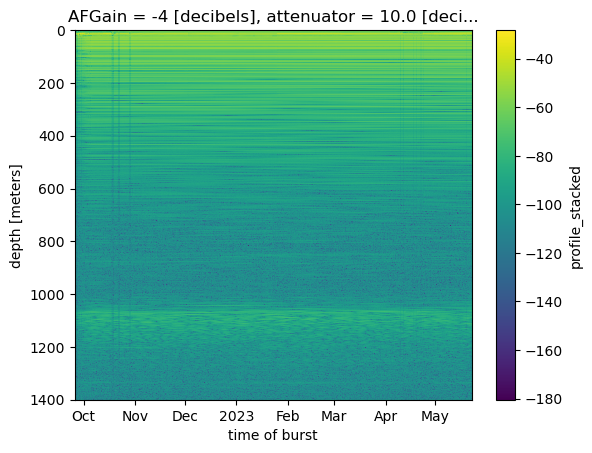

In [15]:
xa.dB(to_plot).plot(x='time')
plt.gca().invert_yaxis()


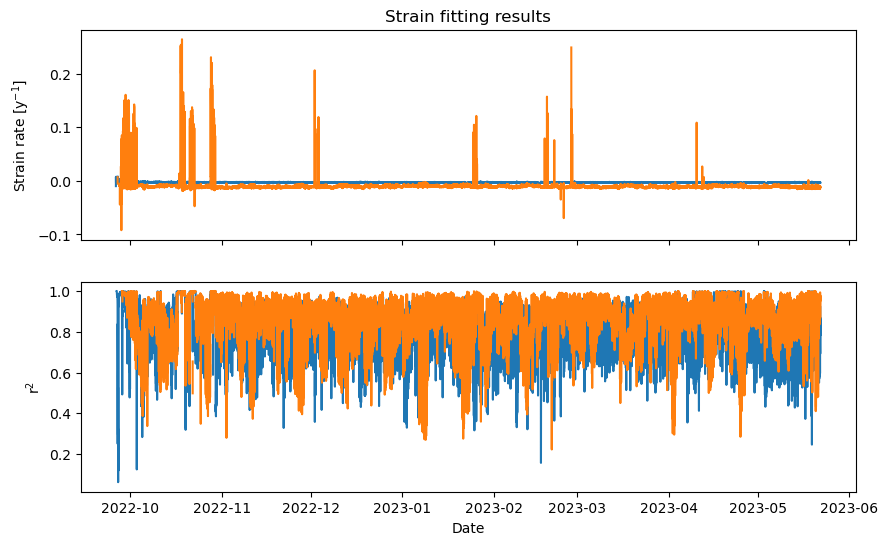

In [16]:
best_window = 80
best_lag = 96
ds_new, fit_t, fit_b = generate_strain_fit(to_plot,best_window,best_lag)

Text(0.5, 0, 'date')

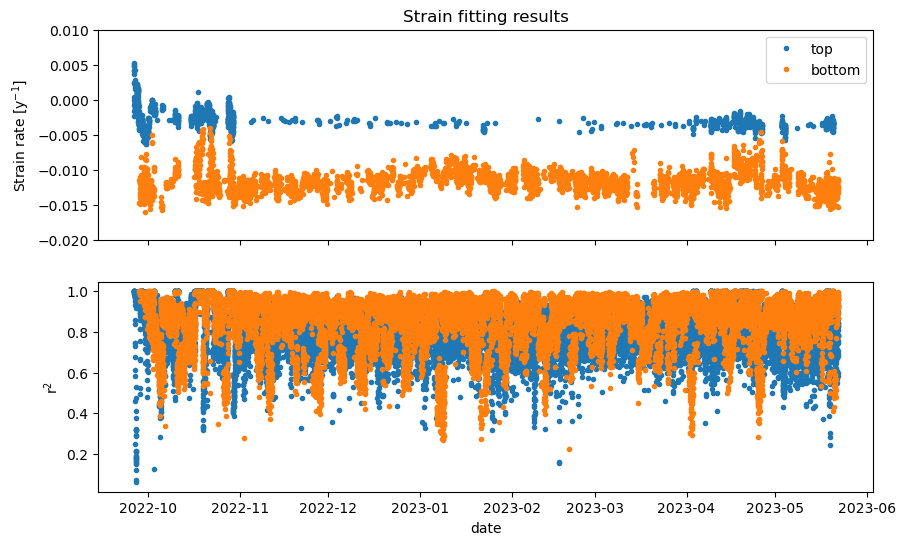

In [26]:
vv = ds_new.range_diff / ds_new.time_diff * 31536000
vv_err = ds_new.err / ds_new.time_diff * 31536000
vv_top = vv.where(vv.profile_range <=600)
r2_t = 1-fit_t.polyfit_residuals/((vv_top-vv_top.mean())**2).sum(dim='profile_range')
vv_bottom = vv.where(vv.profile_range > 500)
r2_b = 1-fit_b.polyfit_residuals/((vv_bottom-vv_bottom.mean())**2).sum(dim='profile_range')

fig, axs = plt.subplots(nrows=2,figsize=(10,6),sharex=True)
axs[0].plot(fit_t.where(r2_t>0.95).time.values,fit_t.where(r2_t>0.95).polyfit_coefficients.sel(degree=1).values,linestyle='None',marker='.',label='top')
axs[0].plot(fit_b.where(r2_b>0.95).time.values,fit_b.where(r2_b>0.95).polyfit_coefficients.sel(degree=1).values,linestyle='None',marker='.',label='bottom')
axs[0].set_ylabel('Strain rate [y$^{-1}$]')
axs[0].set_title('Strain fitting results')
axs[0].set_ylim([-0.02, 0.01])
axs[0].legend()
axs[1].plot(fit_t.time.values,r2_t.values,linestyle='None',marker='.')

axs[1].plot(fit_b.time.values,r2_b.values,linestyle='None',marker='.')

axs[1].set_ylabel('r$^2$')
axs[1].set_xlabel('date')


Text(0.5, 0.01, 'vertical velocity [m y$^{-1}$]')

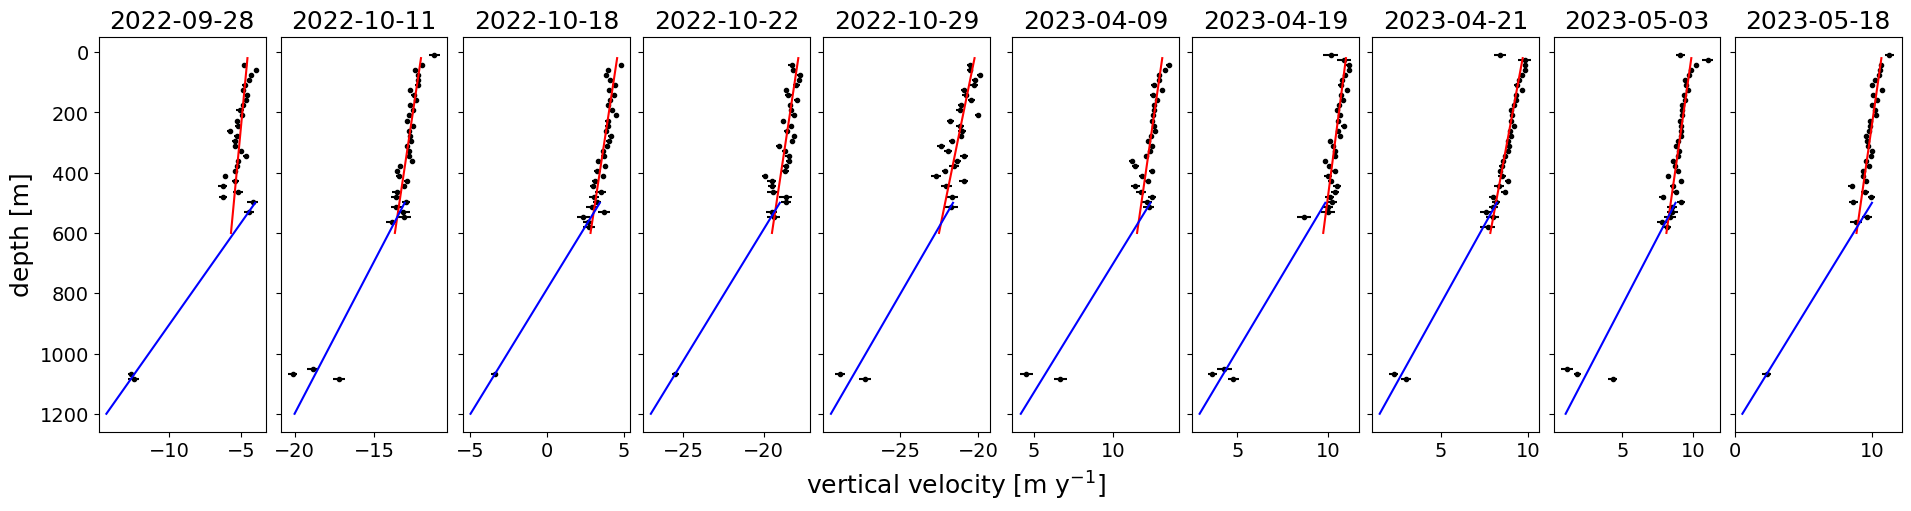

In [28]:
fig1, axs_1 = plt.subplots(ncols=10,figsize=(19,5),sharey=True,layout='constrained')
#fig1.suptitle('Strain fitting (\u03B5\u0307 in 10$^{-3}$ yr$^{-1}$)',fontsize=18)
filter_fit_top = fit_t.where(r2_t>0.95).where( r2_b>0.95).dropna(dim='time',how='all')
filter_fit_bottom = fit_b.where(r2_t>0.95).where(r2_b>0.95).dropna(dim='time',how='all')
filter_vv = vv.where(r2_t>0.95).where(r2_b>0.95).dropna(dim='time',how='all')
filter_vv_err = vv_err.where(r2_t>0.95).where(r2_b>0.95).dropna(dim='time',how='all')

plt_count = 0
for i in np.arange(0,len(filter_vv),len(filter_vv)//10):
    axs_1[plt_count].errorbar(filter_vv.isel(time = i) ,filter_vv.profile_range,yerr=None,xerr=filter_vv_err.isel(time = i),linestyle='',marker='.',color='k',zorder=1)
    slope_top = filter_fit_top.polyfit_coefficients.sel(degree=1).isel(time=i).values*np.linspace(20,600)+filter_fit_top.polyfit_coefficients.sel(degree=0).isel(time=i).values
    
    slope_bottom = filter_fit_bottom.polyfit_coefficients.sel(degree=1).isel(time=i).values*np.linspace(500,1200)+filter_fit_bottom.polyfit_coefficients.sel(degree=0).isel(time=i).values

    axs_1[plt_count].plot(slope_top,np.linspace(20,600),color='r',zorder=2)
    axs_1[plt_count].plot(slope_bottom,np.linspace(500,1200),color='b',zorder=2)
    unit = ''#'x10$^{-3}$ yr$^{-1}$'
    #axs_1[plt_count].text(-10,300, f"\u03B5\u0307= {fit.polyfit_coefficients.sel(degree=1).isel(time=i).values*1000:.2g}"+unit,color = 'r',fontsize=14)
    axs_1[plt_count].set_title(f'{str(filter_vv.time.isel(time = i).values)[0:10]}',fontsize=18)
    #axs_1[plt_count].set_xlim([-50,10])
    #axs_1[plt_count].set_ylim([20,600])
    axs_1[plt_count].tick_params(axis='both', which='major', labelsize=14)
    plt_count += 1
    if plt_count == 10:
        break

axs_1[0].invert_yaxis()

axs_1[0].set_ylabel('depth [m]',fontsize=18)
fig1.supxlabel('vertical velocity [m y$^{-1}$]',fontsize=18)